# Esercitazione 1 

### Laboratorio di Simulazione Numerica

Il materiale relativo all'esercitazione uno è suddiviso come segue nella cartella `Lab_01`:
i codici sono raccolti nelle cartelle `1.1, 1.2, 1.3`, corrispondenti alle consegne dell'esercitazione;
i risultati relativi agli esercizi svolti sono raccolti nella cartella `Results`;

---
__Nota sul codice:__ in questa esercitazione presento il metodo `blocking` nella sua versione finale (cioè quella utilizzata anche nelle altre esercitazioni), nel modo che riporto più avanti. Avendo scritto questo tipo di metodo in una seconda fase di elaborazione, nel codice corrispondente alla seconda consegna il metodo è leggermente diverso. 

---

La struttura del Jupyter Notebook è la seguente:

- 1.0 caricamento dei pacchetti e introduzione;
- 1.1 analisi delle performance del generatore di numeri pseudo-casuali presentato in `random.cpp/h`: stima di valor medio e varianza di variabili casuale estratte da distribuzione uniforme, analisi della distribuzione dei valori di $\chi^2$ a condizioni assegnate;
- 1.2 esperienza della validità del teorema del limite centrale (CLT);
- 1.3 una prima simulazione numerica: l'esperimento di Buffon.


## 1.0 - caricamento pacchetti e introduzione

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sc
from scipy.stats.distributions import chi2

In [2]:
sns.set_theme(font_scale=1.8, style='whitegrid') 

#### Caricamento dei risultati

In [3]:
uniform = np.loadtxt("Results/results.dat")
chiquad = np.loadtxt("Results/chiquad.dat")
chi_10k = np.loadtxt("Results/chiquad_10k.dat")
chi = np.loadtxt("Results/chiquad_block.dat")
TLC_uni = np.loadtxt("Results/TLC_uniform.dat")
TLC_exp = np.loadtxt("Results/TLC_exponential.dat")
TLC_cau = np.loadtxt("Results/TLC_cauchy.dat")
buffon = np.loadtxt("Results/buffon.dat")

Con questo primo esercizio prendiamo dimestichezza con il generatore lineare congruenziale (LCG) di numeri pseudo-casuali  che viene utilizzato largamente all'interno del corso di LSN. 

## 1.1 - stima di valore atteso e varianza, analisi del $\chi^2$

### Stima di $\mu$ e $\sigma^2$

In questo primo esercizio abbiamo valutato il valore atteso e la varianza di una variabile $r$, generata a partire dal metodo `Rannyu()` del codice proposto come LCG. La nostra intenzione è quella di verificare se i momenti della distribuzione, che sono soluzione degli integrali:

$$ \langle r\rangle = \int_0^1 r \, \mathrm{d}r, \qquad \qquad \langle(r-0.5)^2\rangle = \int_0^1 (r-0.5)^2 \mathrm{d}r, $$

sono compatibili con la teoria; un buon generatore di numeri casuali secondo la distribuzione uniforme in $[0,1)$ deve avere media 1/2 e varianza 1/12. 

Volendo stimare i valori degli integrali e le rispettive incertezze, abbiamo approfondito un metodo che ne permette il calcolo in modo più consistente, noto come _blocking method_. L'idea consiste nello svolgere una media iterativa su $N$ misure di una variabile, ciascuna delle quali è ottenuta come media di $M/N=L$ realizzazioni (chiameremo $L$ __taglia__ del blocco). Questo metodo si basa sul teorema del limite centrale: sappiamo che la stima di un certo valore che può essere campionato da una distribuzione qualsiasi (e che ha valore atteso $\mu$ e una varianza finita $\sigma^2$), tipicamente, tende a distribuirsi attorno al valore vero come una gaussiana centrata in $\mu$ e avente varianza $\sigma^2/n$ se il numero di realizzazioni $n$ è grande a sufficienza. Proprio per questo consideriamo come "misura" la media delle realizzazioni eseguite in un singolo blocco. Per avere una stima ancora più accurata, a questo punto, si calcola la media iterativa delle misure ricavate sui blocchi.

Per implementare in modo pratico il metodo, ho deciso di definire la classe `Statistic`, contenente il metodo `blocking(int M, int N, Measure* thismeasure, string filename)`, con il quale implemento la stima su $N$ blocchi di $M$ realizzazioni; queste sono concretizzate nel modo utile all'esercizio a partire dalla classe astratta `Measure`. La stringa `filename` è il nome del file in cui stampo i risultati. Il metodo `thismeasure->get_measure()`, in questo esercizio, viene implementato come estrazione di una variabile casuale $r$ da distribuzione uniforme e, successivamente, come calcolo della varianza relativa alla $r$ estratta.

---

Per la stima di valore atteso e varianza ho eseguito il blocking method utilizzando $M=10^4$ realizzazioni e $N=10^2$ blocchi.

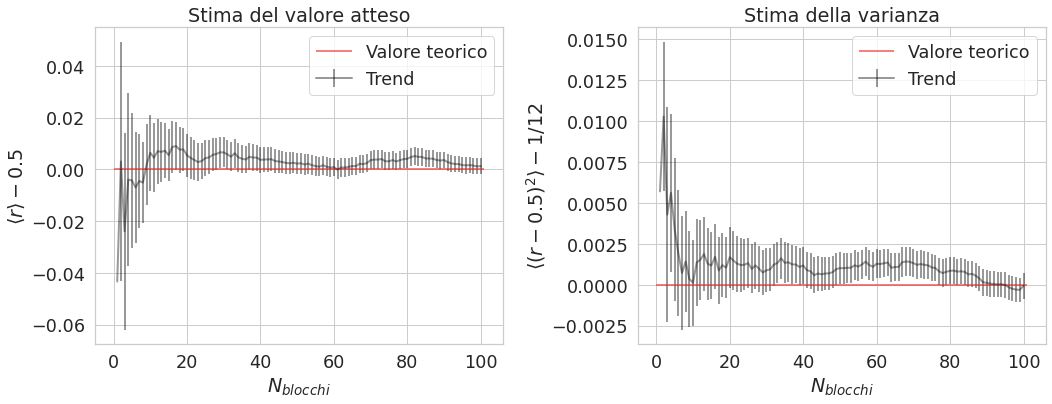

In [16]:
x = np.arange(1,101)

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.title(r"Stima del valore atteso")
plt.errorbar(x, uniform.T[0]-0.5, yerr=uniform.T[1], color='black', alpha=0.4, label='Trend', linewidth=2)
plt.hlines(0,0,101, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=2, alpha=0.6)
plt.ylabel(r"$\langle r \rangle-0.5$")
plt.xlabel(r"$N_{blocchi}$")
plt.legend()

plt.subplot(1,2,2)
plt.title(r"Stima della varianza")
plt.errorbar(x, uniform.T[2]-1/12, yerr=uniform.T[3], color='black', alpha=0.4, label='Trend', linewidth=2)
plt.hlines(0,0,101, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=2, alpha=0.6)
plt.ylabel(r"$\langle (r-0.5 )^2\rangle-1/12$")
plt.xlabel(r"$N_{blocchi}$")
plt.legend()

plt.tight_layout()

plt.show()

**Figura 1:** a sinistra, stima del valore atteso di $r$ in funzione del numero di blocchi, a destra stima della varianza di $r$ in funzione del numero di blocchi. In entrambi i casi l'incertezza, rappresentata in barra d'errore, denota compatibilità con il valore teorico, rappresentato in rosso (la linea è collocata sullo zero perché, per comodità, abbiamo sottratto alle misure effettuate il valore teorico atteso per media e varianza).

### Analisi del $\chi^2$

Per verificare in modo più accurato la bontà del nostro generatore di numeri casuali abbiamo calcolato un $\chi^2$ associato al processo. Più precisamente, ho analizzato la distribuzione di 100 variabili  $\chi^2$, ognuna delle quali valutata sulla distribuzione di $M=10^4$ variabili $r_i$ in $n=100$ intervalli uguali in cui ho diviso $[0,1)$. Per svolgere questo controllo ho sfruttato il metodo `Rannyu` fornito dalla classe `Random` per generare numeri nell'intervallo $[0,1)$. Ho successivamente moltiplicato ciascun valore $r_i$ per 100 e ne ho preso la parte intera $\lfloor r_i \rfloor$. Ho dunque aumentato di 1 il valore di un `vector` di contatori nella posizione corrispondente all'indice $\lfloor r_i \rfloor$. Una volta accumulate le variabili contatore, che chiamo $n_i$, con $i=1,...,100$, ho calcolato i chi quadro come segue:

$$ \chi^2 = \sum_{i=1}^{100} \frac{(n_i-\langle n_i \rangle)^2}{\langle n_i \rangle}. $$ 

Questa scelta è un'approssimazione motivata dal fatto che, per $ n \ll M $ si ha che $\sigma_i^2\approx n/M \equiv \langle n_i \rangle$.

Ho svolto per cento volte questa operazione e il risultato sono altrettanti valori di $\chi^2$ rappresentati nel grafico seguente.

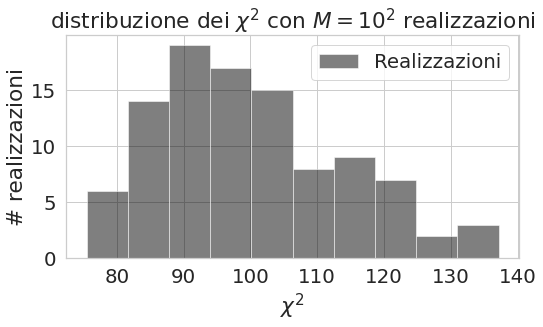

In [10]:
plt.figure(figsize=(8,5))

plt.title("distribuzione dei $\chi^2$ con $M=10^2$ realizzazioni")
plt.hist(chiquad, bins=10, color='black', alpha=0.5, density=False, label='Realizzazioni')
plt.xlabel('$\chi^2$')
plt.ylabel('# realizzazioni')
plt.legend()

plt.tight_layout()

plt.show()

**Figura 2:** istogramma che rappresenta la distribuzione dei valori di $\chi^2$ ottenuti ripetendo cento volte il calcolo. La distribuzione si presenta irregolare e asimmetrica, inoltre vengono registrati valori di chi quadro anche molto superiori al valore atteso, cioè $\chi^2 = 100$. Questo fenomento però potrebbe e dovrebbe essere atteso considerando la reale distribuzione della variabile chi quadro. 

Per capire se i miei dati sono rappresentativi di un malfunzionamento del generatore oppure se i risultati sono perfettamente in linea con le aspettative statistiche della distribuzione dei chi quadrati ho deciso di effettuare un numero maggiore di realizzazioni del $\chi^2$: ho eseguito il calcolo della statistica per diecimila volte, con l'intenzione di osservare più nel dettaglio la forma della distribuzione. I risultati ottenuti sono riportati nella figura seguente.

In [11]:
fit_chi = sc.chi2.fit(np.asarray(chi_10k))
fit_chi

x_coord = np.linspace(0,170,1000)

chi2_pdf = sc.chi2.pdf(x_coord, fit_chi[0], fit_chi[1], fit_chi[2])
print("Parametri del fit: ", fit_chi)

Parametri del fit:  (91.19887814212387, 4.623629464692604, 1.0362987446070062)


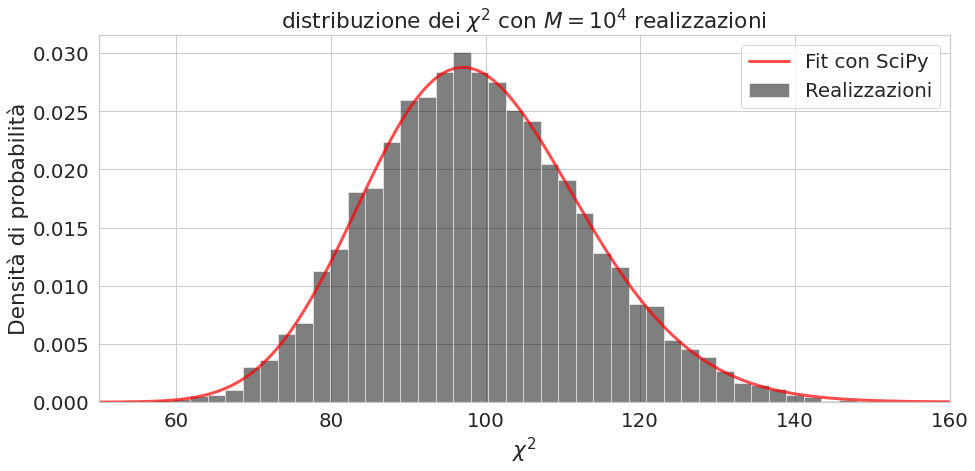

In [12]:
plt.figure(figsize=(14,7))

plt.title("distribuzione dei $\chi^2$ con $M=10^4$ realizzazioni")
plt.hist(chi_10k, bins=50, color='black', alpha=0.5, density=True, label='Realizzazioni')
plt.plot(x_coord, chi2_pdf, color='red', alpha=0.7, linewidth=3, label='Fit con SciPy')
plt.xlabel('$\chi^2$')
plt.ylabel('Densità di probabilità')
plt.legend()
plt.xlim(50,160)

plt.tight_layout()

plt.show()

__Figura 3:__ oltre a calcolare un numero maggiore di valori del chi quadro ho anche voluto eseguire un fit con l'utilizzo della libreria `scipy.stats`. Ciò che si ottiene è effettivamente una distribuzione che "fitta bene" i dati ottenuti. Se poi vogliamo andare a valutare il valore atteso del chi quadro secondo la p.d.f. ottenuta tramite il fit, stampando dunque il primo dei parametri ottenuti, otteniamo: $\langle \chi^2 \rangle \simeq 91.$ Per concludere, tenendo in considerazione il valore atteso ottenuto tramite il fit e l'aderenza dei dati alla p.d.f. ottenuta con lo stesso, mi sento di poter __rigettare__ l'ipotesi che il generatore che stiamo utilizzando __non__ fornisca variabili distribuite in modo uniforme.

## 1.2 - Studiamo il CLT

In questo secondo esercizio vogliamo controllare la validità del teorema del limite centrale (CLT). 
Secondo il CLT, definita una variabile $A_N = \frac{1}{N}\sum_{i=1}^N x_i$, con $x_i$ variabili estratte da distribuzioni qualsiasi (ciascuna caratterizzata dai propri momenti algebrici), tali che la varianza per ciascuna di queste distribuzioni sia finita, la distribuzione di $A_N$ tende ad una gaussiana al tendere di $N$ a infinito.

La condizione sui momenti centrali di ordine due che devono soddisfare le variabili è cruciale: se consideriamo variabili la cui varianza diverge (ad esempio variabili estratte da una distribuzione di Cauchy), vedremo che la distribuzione degli $A_N$ tende ad altre distribuzioni (altri attrattori).
Per evidenziare questi due aspetti abbiamo svolto le seguenti operazioni:
- campionato $M=10^4$ variabili $A_N$, ottenute tramite media aritmetica di $N=\{1,2,10,100\}$ variabili $x_i$; 
- svolto questa operazione considerando diverse distribuzioni per $x_i$: uniforme in $[0,1)$, esponenziale con $\lambda=1$ e cauchy con $\mu=0, \Gamma=1$.

Questo ci permette di evidenziare il bacino di attrazione della distribuzione gaussiana e il fatto che la distribuzione di Cauchy non ne fa parte, tendendo invece alla stessa distribuzione di Cauchy al crescere del valore di $N$.

---

Per svolgere il campionamento delle variabili $x_i$ a partire dalle p.d.f. citate abbiamo implementato il metodo dell'inversione. partendo da $r_i$ generate da $\mathcal{U}[0,1)$ e sfruttando l'equivalenza delle c.d.f.:

$$ r = \int_{-\infty}^x p_x(x')dx', $$

e invertendo l'espressione trovata siamo in grado di campionare le $x_i$ sfruttando i valori $r_i$.

#### Fit gaussiani e cauchy per le distribuzioni ottenute

In [7]:
fit_uni = sc.norm.fit(TLC_uni.T[3])
fit_exp = sc.norm.fit(TLC_exp.T[3])
fit_cau = sc.cauchy.fit(TLC_cau.T[3])

y = np.linspace(-10, 10, 10000)

pdf_uni = sc.norm.pdf(y, fit_uni[0], fit_uni[1])
pdf_exp = sc.norm.pdf(y, fit_exp[0], fit_exp[1])
pdf_cau = sc.cauchy.pdf(y, fit_cau[0], fit_cau[1])

#### Distribuzione delle variabili $A_N$

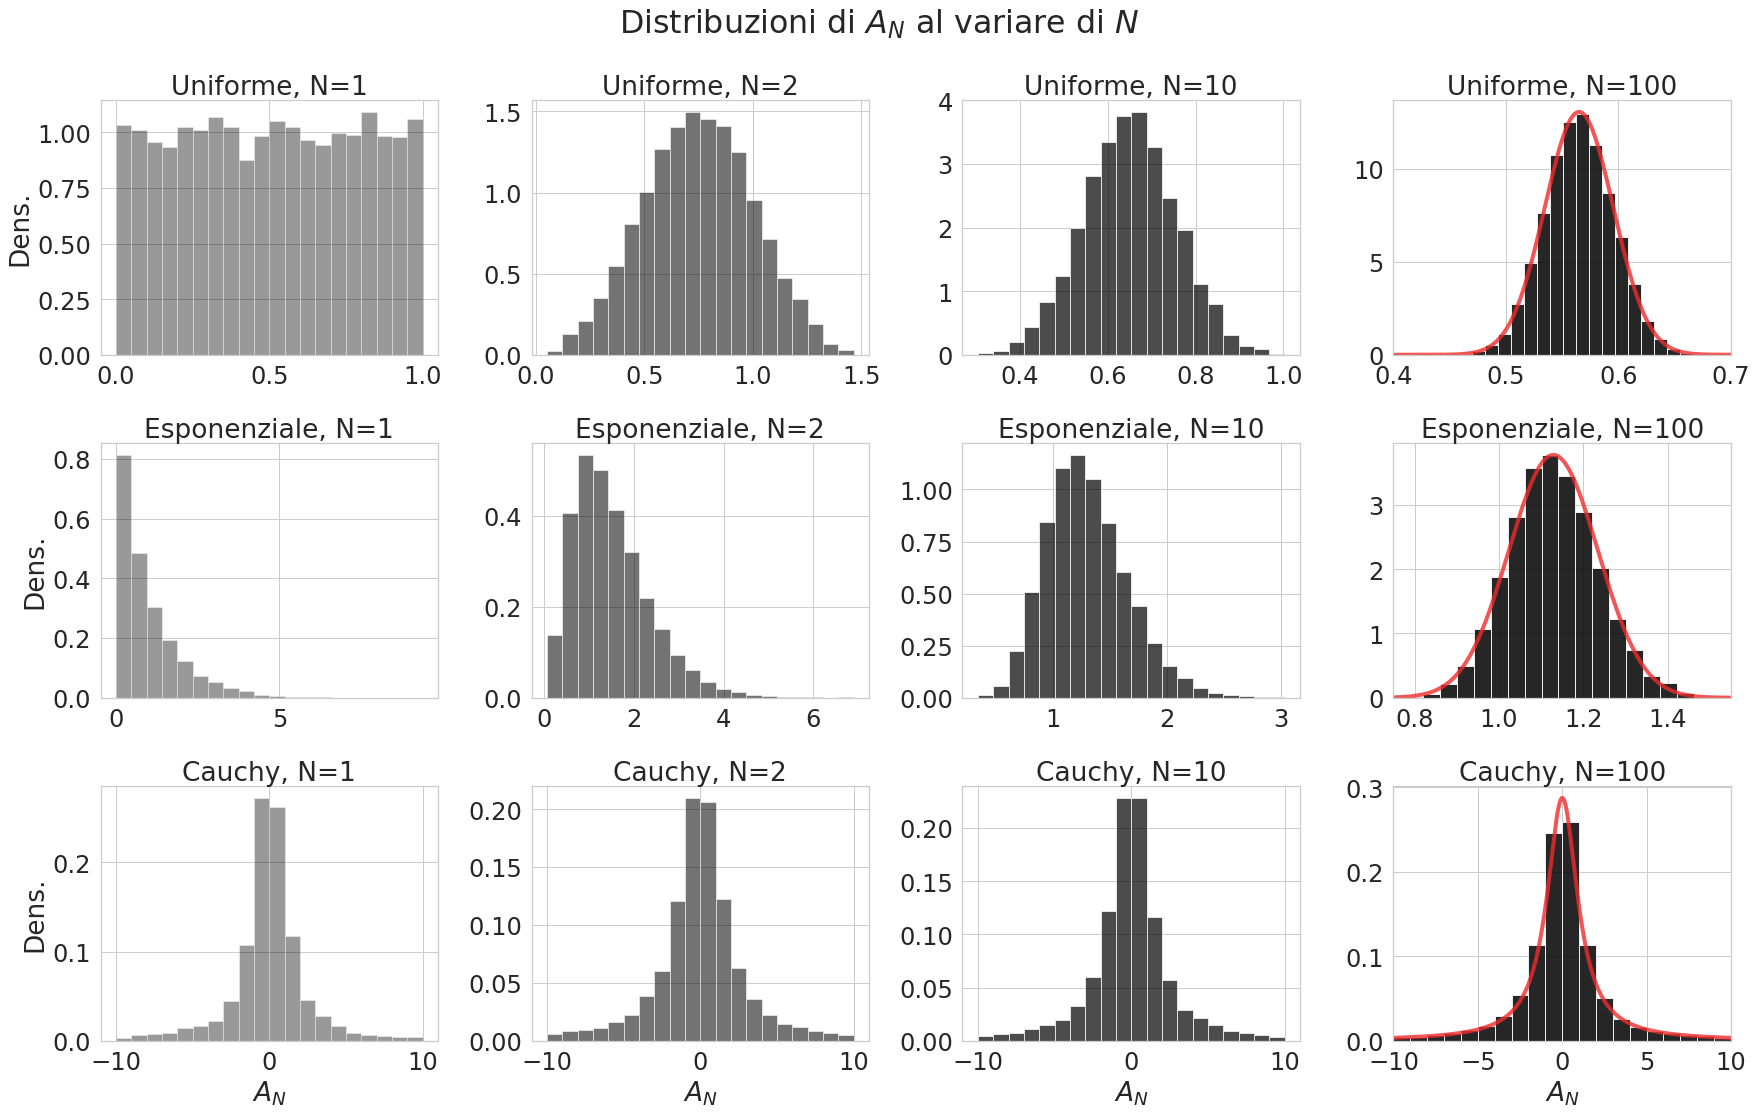

In [10]:
N = [1,2,10,100]
sns.set_theme(font_scale=2.2, style='whitegrid') 

plt.figure(figsize=(25,16))
plt.suptitle('Distribuzioni di $A_N$ al variare di $N$')

for i in range(12):
    plt.subplot(3,4,i+1)
    if(i<4):
        if(i==0): plt.ylabel('Dens.')
        plt.title("Uniforme, N="+str(N[i]))
        plt.hist(TLC_uni.T[i], bins=20, color='black', alpha=0.4+i*0.15, density=True)
        if(i==3):
            plt.plot(y, pdf_uni, color='#EE2C2C', linewidth=4, alpha=0.8)
            plt.xlim(0.4,0.7)
    elif(i<8):
        if(i==4):
            plt.ylabel('Dens.')
        plt.title('Esponenziale, N='+str(N[i-4]))
        plt.hist(TLC_exp.T[i-4], bins=20, color='black', alpha=0.4+(i-4)*0.15, density=True)
        if(i==7):
            plt.plot(y, pdf_exp, color='#EE2C2C', linewidth=4, alpha=0.8)
            plt.xlim(0.75,1.55)
    elif(i<12):
        if(i==8):
            plt.ylabel('Dens.')
        plt.title('Cauchy, N='+str(N[i-8]))
        plt.hist(TLC_cau.T[i-8], bins=20, color='black', alpha=0.4+(i-8)*0.15, range=(-10,10), density=True)
        if(i==11):
            plt.plot(y, pdf_cau, color='#EE2C2C', linewidth=4, alpha=0.8)
            plt.xlim(-10,10)
        plt.xlabel(r'$A_N$')
plt.tight_layout()
plt.savefig('TLC.png')
plt.show()    

**Figura 4:** nella prima riga, da sinistra verso destra istogrammi che rappresentano le distribuzioni della variabile $A_N$ ottenuta come media aritmetica rispettivamente di $N=\{1,2,10,100\}$ variabili estratte da p.d.f. uniforme. La quarta figura presenta anche il fit effettuato con distribuzione gaussiana. Le successive due righe rappresentano la stessa configurazione, considerando, dall'alto verso il basso, sovrapposizione di variabili estratte da p.d.f. esponenziale e cauchy. Nei casi in cui la variabile $A_N$ viene ottenuta come sovrapposizione di variabili estratte da p.d.f. gaussiana o esponenziale vediamo la sua distribuzione tendere ad una gaussiana all'aumentare di $N$. In accordo con il CLT, nel terzo caso la distribuzione degli $A_N$ rimane una distribuzione di Cauchy, indipendentemente dal valore di $N$. 

Ho svolto infine il calcolo del p-value tramite la statistica di test di Kolmogorov-Smirnov, per analizzare in modo quantitativo i risultati. A giudicare dai valori ottenuti (e dei fit) scartiamo senza dubbio l'ipotesi che il campione rappresentato in basso a destra in figura 4 sia statisticamente compatibile con una distribuzione gaussiana. Al contrario, tramite i p-value relativi agli altri due casi (l'uniforme ancor più della esponenziale) non mi sento di scartare questa ipotesi.

In [33]:
print("P-value KS-Test, An da uniformi     : ", sc.kstest(TLC_uni.T[3], 'norm', args=(fit_uni[0],fit_uni[1]))[1])
print("P-value KS-Test, An da esponenziali : ", sc.kstest(TLC_exp.T[3], 'norm', args=(fit_exp[0],fit_exp[1]))[1])
print("P-value KS-Test, An da Cauchy       : ", sc.kstest(TLC_cau.T[3], 'norm', args=(fit_cau[0],fit_cau[1]))[1])

P-value KS-Test, An da uniformi     :  0.8807993344827908
P-value KS-Test, An da esponenziali :  0.008041199510104456
P-value KS-Test, An da Cauchy       :  8.998814554541353e-147


Riporto i valori ottenuti nel caso in cui non si leggano su GitHub gli output delle funzioni `print`:

- p-value da KS-Test e variabili estratte da uniforme    : $p_v\simeq0.88$;
- p-value da KS-Test e variabili estratte da esponenziale: $p_v\simeq0.008$;
- p-value da KS-Test e variabili estratte da cauchy      : $p_v \simeq 9\cdot 10^{-147}$;




## 1.3 - Esperimento di Buffon

In questo terzo esercizio abbiamo implementato l'esperimento di Buffon per stimare il valore di $\pi$. Egli dedusse che, disegnando su un piano un fascio di rette parallele e distanziate l'una dall'altra da una distanza $d$, il numero di volte $N_{colpi}$ che un ago di lunghezza $L<d$  lanciato casualmente sul piano intersecava le rette poteva essere utilizzato per stimare $\pi$; infatti, si può dimostrare che la probabilità che l'ago tocchi una delle righe è $P=2L/\pi d$, da cui:

$$ \pi = \frac{2L}{Pd} = \lim_{N_{lanci}\to\infty} \frac{2L N_{lanci}}{N_{colpi}d}.$$

L'idea alla base della mia implementazione consiste nel generare un valore  $y_1$ che coincide con l'ordinata di una delle estremità del mio ago. Genero questo valore all'interno di un range $[0,d)$. A questo punto ho bisogno di generare in modo uniforme il seno di un angolo, così da moltiplicarlo per $L$ e ottenere il valore di $y_2$, cioè la seconda estremità dell'ago. Se questa assume un valore superiore a $d$ o inferiore a $0$ aggiungo una unità al mio conteggio.
Per implementare la generazione del seno ho scritto un metodo, `generate_sin_angle`, che ho aggiunto alla classe `Random` e in cui genero coppie di punti $(x,y)$ nel semipiano che contiene la semicirconferenza positiva di raggio uno; accetto solamente le coppie di punti che ricadono all'interno della semicirconferenza. Così facendo posso valutare il seno dell'angolo.

Nella simulazione ho utilizzato il metodo `blocking` introdotto in precedenza. Questa volta le realizzazioni si concretizzano nel calcolo del valore di $\pi$. Ho eseguito $M=10^7$ realizzazioni, suddivise su un totale di $N=100$ blocchi. Ho inoltre eseguito la simulazione utilizzando i valori $d=5$ e $L=3$.

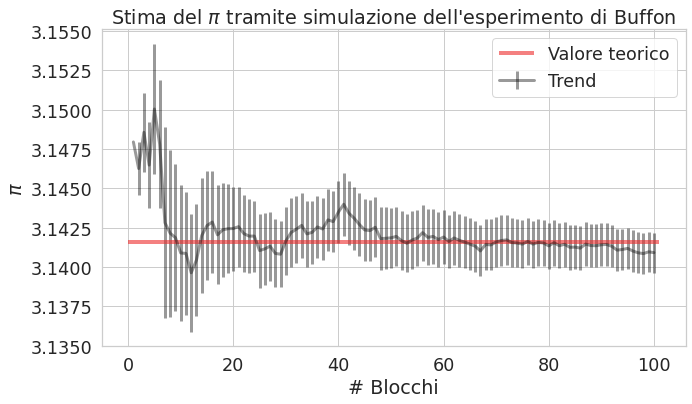

In [13]:
x = np.arange(1,101)
sns.set_theme(font_scale=1.6, style='whitegrid')

plt.figure(figsize=(10,6))

plt.title("Stima del $\pi$ tramite simulazione dell'esperimento di Buffon")
plt.errorbar(x, buffon.T[0], yerr=buffon.T[1], color='black', alpha=0.4, label='Trend', linewidth=3)
plt.hlines(np.pi,0,101, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=4, alpha=0.6)
plt.ylabel("$\pi$")
plt.xlabel("# Blocchi")
plt.legend()
plt.tight_layout()
plt.show()

**Figura 5:** stima del valore atteso di $\pi$ in funzione del numero di blocchi. Il risultato ottenuto e che possiamo visualizzare in corrispondenza del blocco numero cento è compatibile con il valore teorico del $\pi$.